# Week 3: Swaps


## FINM 37400: Fixed Income

### Mark Hendricks

#### Winter 2023

In [5]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import treasury_cmds 
from treasury_cmds import holidays,nelson_siegel,extract_spot_curves,intrate_to_discount

In [1]:
def next_business_day(DATE):
    
    ONE_DAY = datetime.timedelta(days=1)
    HOLIDAYS_US = holidays.US()

    next_day = DATE
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

$\newcommand{\value}{V}$
$\newcommand{\price}{P}$
$\newcommand{\float}{\text{float}}$
$\newcommand{\freq}{\kappa}$
$\newcommand{\tbond}{\text{fixed}}$
$\newcommand{\cpn}{c}$
$\newcommand{\spread}{s}$
$\newcommand{\swap}{\text{swap}}$
$\newcommand{\swaprate}{\cpn_{\swap}}$
$\newcommand{\cashflow}{C}$
$\newcommand{\notional}{K}$

# Swap Basics

### Repeated from Markets M.3. Note

### Definition

A **swap** is an over-the-counter derivative. 
- Two counterparties agree at $t$ to swap payments on future dates.
- The payments may be based on fixed vs floating interest rates on the same currency or fixed interest rates across two currencies.
- The swap designates a **notional** base for the interest rates, but the notional is not exchanged.

### Fixed-for-Floating

A **fixed-for-floating** interest-rate swap is an agreement with the following obligations
- make fixed payments at an annualized rate, $\cpn_\swap$, on a notional $\notional$, up to a maturity date $T$.
- make payments derived from a variable short-term rate, $r(t)$.

Consider the swap 
- exchanging payments at frequency $\freq$
- thus making payments every $\tau = 1/\freq$.
- the interest rate quoted is compounded at frequency $\freq$.

Cashflow, $\cashflow$, at each swap period is

$\begin{align}
\cashflow(T_i) = \notional\, \tau\left[r_\freq(T_{i-1},T_i)-\cpn_\swap\right]
\end{align}$

### Swap Rate

The fixed rate in the fixed-for-floating swap, $\cpn_\swap$, is known as the **swap rate**.

Note that it is specific to
- the index underlying the floating rate
- the maturity
- the frequency of payments
- the frequency of the compounding of the rates quoted

### Specifications 

Frequency
- floating payment is often quarterly
- fixed payment is often semiannual

Floating rates
- floating rate bonds typically use major money-market indexes.
- in the past, **LIBOR was dominant** as a floating rate.
- now, **SOFR** and the **Fed Fund Effective Rate** dominate for dollar-denominated instruments.

SOFR and the Fed Funds Rate are discussed in depth later. 
- For now, just note that these are short-term interest rates.

### No cost to initiate

Like a forward, there is no cost to initiate the swap.
- There is no cashflow immediately.
- The swap rate is set such that the value is initially zero.
- This is a similarity to the forward, (FRA or forward contract), where the forward rate is such that the initial value is zero.

This aspect is an important part of why swaps (and forwards) have become so important for managing interest-rate risk: they allow one to change the duration of the portfolio without any initial price.

### Example: SOFR Swaps

The floating rate swapped is **SOFR, discussed below**.

For now, just consider SOFR as a variable, short-term, nearly risk-free rate. We could find similar results if we considered the 13-week Tbill rate as the underyling.

<img src="../refs/bb_sofr_swap_description.png"/>

# Swap Pricing and the Swap Curve

## Swaps, Forwards, and Floaters

The key to pricing swaps is to see the relationship to other fixed-income instruments.

#### Swap as bonds
- Above, we noted the value of the swap is a long-short position of floating and fixed bond.

#### Swap as forwards
- A forward can be seen as a single-date, swap.
- Thus, a swap is a portfolio of forwards.

## Swap Curve

On a given date, consider the quoted swap rate, $\swaprate$, across swaps of various maturities.

This is the **swap curve**. 

Below, the swap curve for the underlying SOFR rate is shown on various dates.

In [6]:
filepath = 'C:/Users/dcste/OneDrive/fixed_income/fixed_income_FORKED/finm-fixedincome-2023\data\sofr_swaps.xlsx'
swaps_raw = pd.read_excel(filepath,sheet_name='data').set_index('Unnamed: 0')
swaps_raw.columns = swaps_raw.columns.astype(float)
swaps_raw.index.name = 'date'
swaps_raw /= 100

# a few of the time-series have extreme outliers
# eliminate them by making 99th quantile NaN
ub = swaps_raw.quantile(1)
swaps = swaps_raw[(swaps_raw < ub)]

In [7]:
swaps

,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,7.000000,8.000000,9.000000,10.000000,15.000000,20.000000,25.000000,30.000000,40.000000,50.000000
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.014546,NaN,0.014712,0.015056,0.015321,0.015612,NaN,NaN,0.016366,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.014556,0.014551,0.014774,0.015142,0.015410,0.015732,0.016075,0.016317,0.016533,0.016809,...,0.020328,0.020451,0.020626,0.020827,0.021414,0.021697,0.021746,0.021622,0.021430,0.021094
2018-01-03,0.014571,0.014565,0.014822,0.015246,0.015492,0.015832,0.016175,0.016417,0.016646,0.016919,...,0.020296,0.020394,0.020550,0.020730,0.021269,0.021557,0.021572,0.021478,0.021290,0.020949
2018-01-04,0.014571,0.014571,0.014945,0.015336,0.015615,0.015991,0.016305,0.016567,0.016824,0.017089,...,0.020534,0.020602,0.020732,0.020897,0.021346,0.021604,0.021607,0.021539,0.021355,0.021017
2018-01-05,0.014582,0.014587,0.014945,0.015338,0.015627,0.015981,0.016315,0.016577,0.016814,0.017089,...,0.020718,0.020800,0.020936,0.021101,0.021600,0.021862,0.021932,0.021788,0.021596,0.021280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,0.009663,0.011315,0.013499,0.014852,0.016230,0.017578,0.018815,0.019872,0.020935,0.021744,...,0.026009,0.026021,0.026066,0.026195,0.026740,0.026593,0.025817,0.024985,0.023060,0.021060
2022-05-24,0.009680,0.011325,0.013472,0.014710,0.016019,0.017335,0.018366,0.019380,0.020329,0.021074,...,0.024918,0.024985,0.025099,0.025265,0.025941,0.025856,0.025136,0.024353,0.022428,0.020445
2022-05-25,0.009722,0.011393,0.013638,0.014760,0.016030,0.017300,0.018310,0.019329,0.020235,0.020967,...,0.024893,0.024988,0.025125,0.025332,0.026090,0.026040,0.025340,0.024570,0.022645,0.020645


In [8]:
tab = swaps.iloc[-1,:].to_frame().T
tabcolnames = list()
for col in tab.columns:
    tabcolnames.append(f'{col:.2f}')

tab.columns = tabcolnames

tab.style.format('{:.2%}')

,0.08,0.17,0.25,0.33,0.42,0.50,0.58,0.67,0.75,0.83,0.92,1.00,1.08,1.17,1.25,1.33,1.42,1.50,1.58,1.67,1.75,1.83,1.92,2.00,2.25,2.50,2.75,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,15.00,20.00,25.00,30.00,40.00,50.00
2022-05-27 00:00:00,1.04%,1.20%,1.39%,1.52%,1.63%,1.75%,1.87%,1.96%,2.05%,2.13%,2.19%,2.26%,2.32%,2.35%,2.39%,2.42%,2.45%,2.46%,2.48%,2.50%,2.51%,2.52%,2.53%,2.53%,2.54%,2.54%,2.54%,2.54%,2.51%,2.50%,2.49%,2.50%,2.51%,2.52%,2.54%,2.62%,2.61%,2.54%,2.46%,2.27%,2.08%


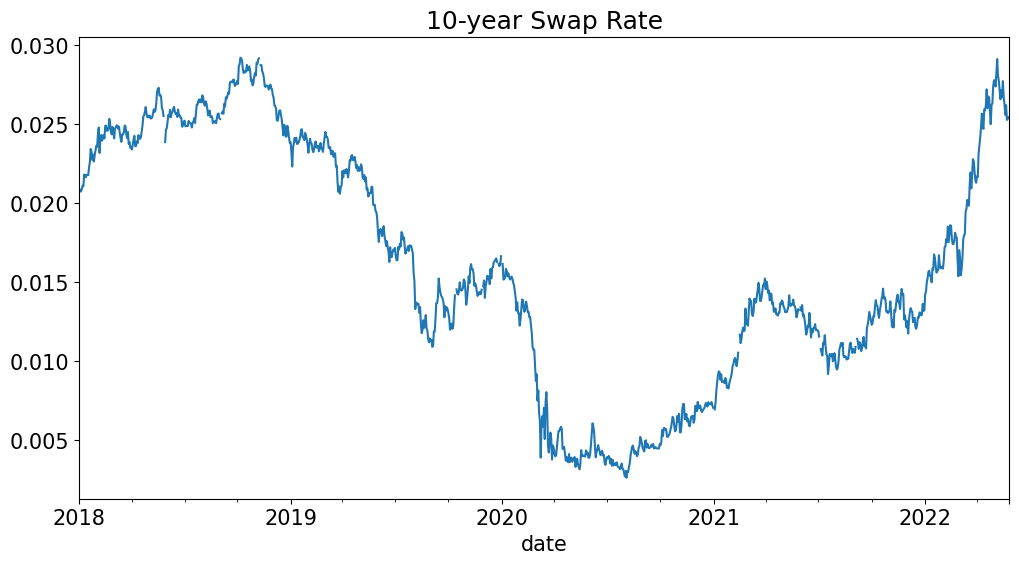

In [9]:
swaps[10].plot(title='10-year Swap Rate')

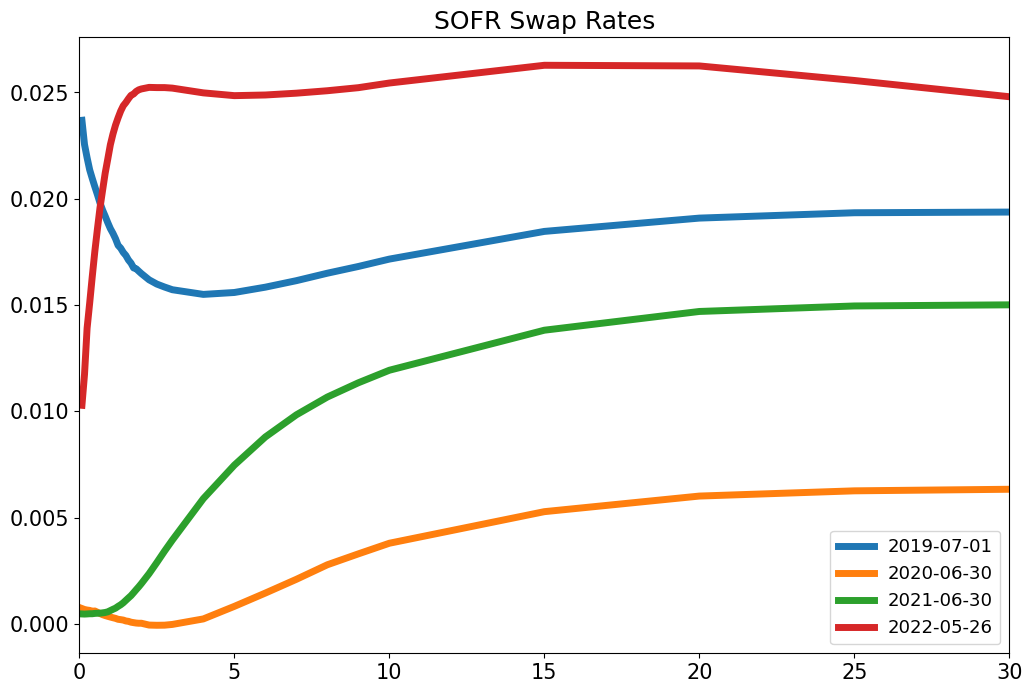

In [23]:
dtset = pd.to_datetime(['2019-06-30', '2020-06-30', '2021-06-30', '2022-05-26'])
dts = [next_business_day(i) for i in dtset]
dts_formatted = [f'{dt:%Y-%m-%d}' for dt in dts]

swaps.loc[dts,:].T.plot(figsize=(12,8),xlim=(0,30),linewidth=5,title='SOFR Swap Rates')
plt.legend(dts_formatted)
plt.show()

### Swap rates move over time

They show a strong factor structure.

That is, the swap rates at different maturities move together.

For a given date, the swap curve can be inferred from the vertical spread among these series.

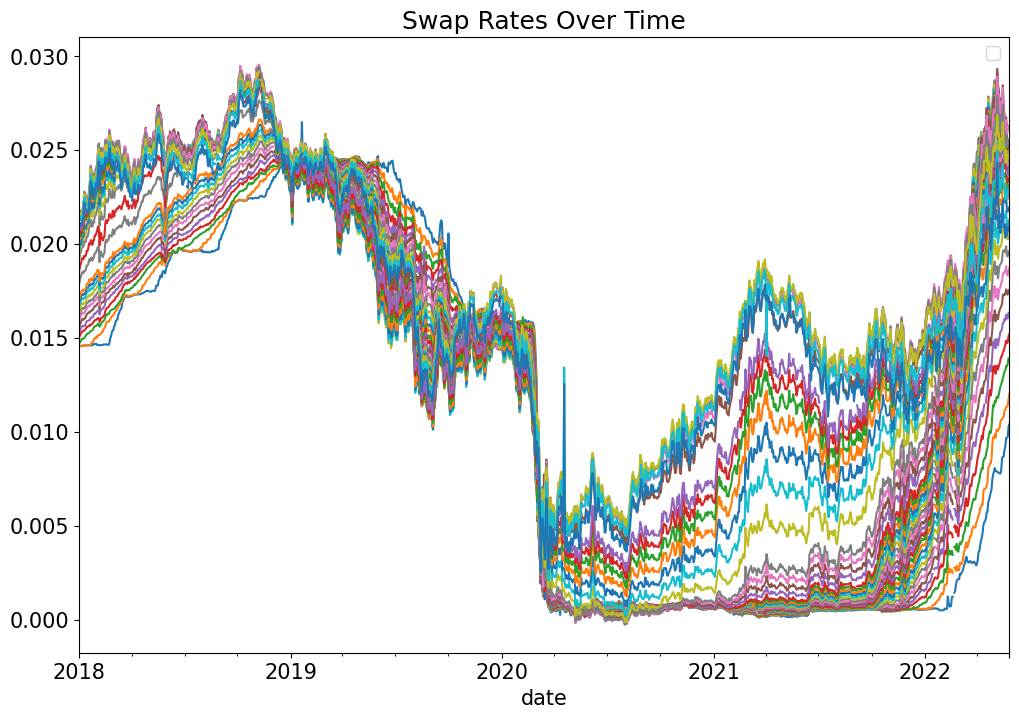

In [24]:
swaps.plot(figsize=(12,8),title='Swap Rates Over Time')
plt.legend([])
plt.show()

## Swap Value

The swapped cashflow (from the perspective of the paying-fixed, receiving floating,) is replicated by holding
* $+$ Floating bond
* $-$ Fixed bond

Thus, value is

$\begin{align}
\value_{\swap}(t,T,\swaprate) = P_{\float}(t,T;0) - P_{\tbond}(t,T;\cpn_{\swap})
\end{align}$

where the frequency, $\freq$, or set of swap dates, $T_i$, are ommitted for notational simplicity.

#### Implicitly defined swap rate

The swap rate, $\swaprate$, is the value that makes the value $0$ at $t=0$:

$\begin{align}
\swaprate \text{ such that }\value_{\swap}(0,T,\swaprate) = 0
\end{align}$


### Swap Pricing Formulas

Consider, for simplicity, a swap with equal frequency of fixed and floating payments.
* Denote the frequency of payments as $\freq$.
* The total number of swap payments is $M=\freq\, T$.
* Let $T_i$ denote the payment dates, with $T_M$ (the final payment) being equal to the total maturity $T$.

Given the replication of the swap as a long floater and short fixed, we can find the value at swap dates easily.
* Recall that $P_\float(T_i,T;0)=100$ on reset/payment dates, $T_i$.
* Below we value it at $t=0$, but any payment date, $T_i$ would be easy.
* Interim dates, $T_{i-1}<t<T_i$ follows directly using the formula in the Floating Rates discussion.

$\begin{align}
\value_{\swap}(0,T;\swaprate) =& 100 - 100\left[\sum_{i=1}^{M} Z(0,T_i)\frac{\cpn_\swap}{\freq} + Z(0,T)\right]\\[6pt]
=& 100\left[1 - Z(0,T) - \frac{\cpn_\swap}{\freq} \sum_{i=1}^{M} Z(0,T_i) \right]
\end{align}$

### Solving for the swap rate

Use the formula above, and recall that $\swaprate$ is set such that this value is 0 at $t=0$.

Then,

$\begin{align}
\swaprate(0,T;\freq) = \freq\, \frac{1-Z(0,T)}{\sum_{i=1}^M Z(0,T_i)}
\end{align}$

where the notation here emphasizes that the swap rate, $\swaprate$ is a function of the quote date, 0, the maturity, $T$, and the frequency of swap payments, $\freq$.

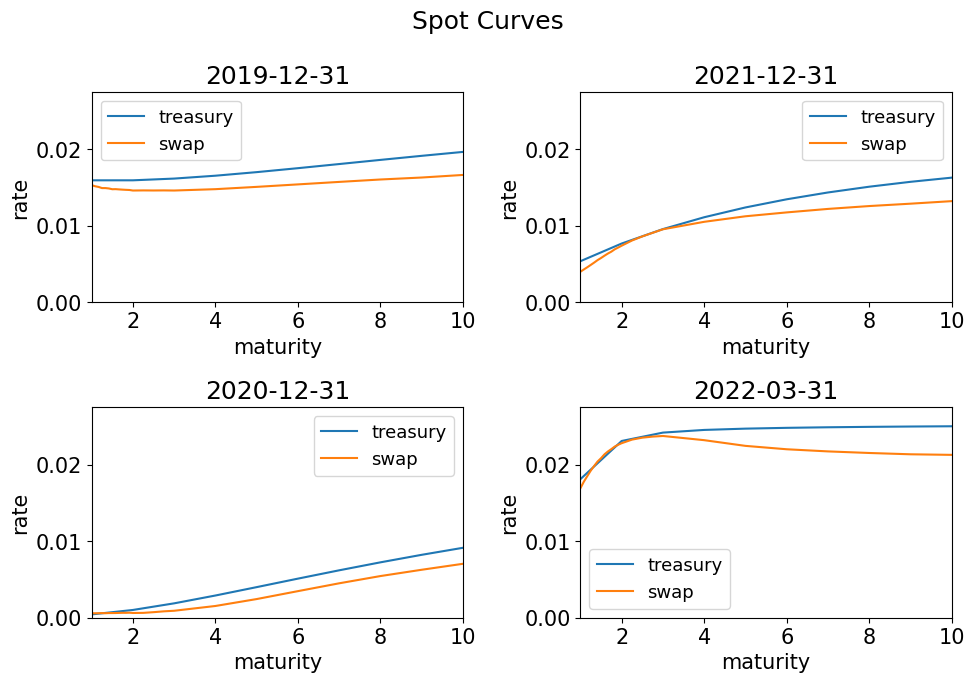

In [29]:
dts = ['2019-12-31','2020-12-31','2021-12-31','2022-03-31']

GRID_UB = 10

ncols = (len(dts)/2 > 1) + 1
nrows = int(np.ceil(len(dts)/ncols))

MODEL = nelson_siegel
DELTA = 1

fig,ax = plt.subplots(nrows,ncols,figsize=(10,14/ncols))

for i,QDATE in enumerate(dts):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        curve_treasury = extract_spot_curves(QDATE, model=MODEL, delta_maturity=DELTA, calc_forward=False)
   
    if ncols>1:
        ax_selected = ax[i%ncols,int(i/ncols)]
    else:
        ax_selected = ax[i]
    
    curve_treasury['spot rate'].loc[:GRID_UB].plot(ax=ax_selected,xlim=(DELTA,GRID_UB))
    swaps.loc[QDATE,:GRID_UB].plot(ax=ax_selected,title=QDATE,ylabel='rate',xlim=(DELTA,GRID_UB),ylim=(0,.0275))
    ax_selected.legend(['treasury','swap'])

plt.suptitle('Spot Curves')
plt.tight_layout()
plt.show()

In [30]:
swaps

,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,7.000000,8.000000,9.000000,10.000000,15.000000,20.000000,25.000000,30.000000,40.000000,50.000000
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.014546,NaN,0.014712,0.015056,0.015321,0.015612,NaN,NaN,0.016366,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.014556,0.014551,0.014774,0.015142,0.015410,0.015732,0.016075,0.016317,0.016533,0.016809,...,0.020328,0.020451,0.020626,0.020827,0.021414,0.021697,0.021746,0.021622,0.021430,0.021094
2018-01-03,0.014571,0.014565,0.014822,0.015246,0.015492,0.015832,0.016175,0.016417,0.016646,0.016919,...,0.020296,0.020394,0.020550,0.020730,0.021269,0.021557,0.021572,0.021478,0.021290,0.020949
2018-01-04,0.014571,0.014571,0.014945,0.015336,0.015615,0.015991,0.016305,0.016567,0.016824,0.017089,...,0.020534,0.020602,0.020732,0.020897,0.021346,0.021604,0.021607,0.021539,0.021355,0.021017
2018-01-05,0.014582,0.014587,0.014945,0.015338,0.015627,0.015981,0.016315,0.016577,0.016814,0.017089,...,0.020718,0.020800,0.020936,0.021101,0.021600,0.021862,0.021932,0.021788,0.021596,0.021280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,0.009663,0.011315,0.013499,0.014852,0.016230,0.017578,0.018815,0.019872,0.020935,0.021744,...,0.026009,0.026021,0.026066,0.026195,0.026740,0.026593,0.025817,0.024985,0.023060,0.021060
2022-05-24,0.009680,0.011325,0.013472,0.014710,0.016019,0.017335,0.018366,0.019380,0.020329,0.021074,...,0.024918,0.024985,0.025099,0.025265,0.025941,0.025856,0.025136,0.024353,0.022428,0.020445
2022-05-25,0.009722,0.011393,0.013638,0.014760,0.016030,0.017300,0.018310,0.019329,0.020235,0.020967,...,0.024893,0.024988,0.025125,0.025332,0.026090,0.026040,0.025340,0.024570,0.022645,0.020645


## Extracting the Discount Curve

The **discount curve**, $Z(t,T)$ can be bootstrapped by inverting the formula for the swap rate above.
- Mathematically, this is similar to extracting the discount curve form treasuries.
- Bootstrap the curve if swap rates are available at the full grid of maturities

For a grid of dates of maturing swaps, $T_i$, 

$\begin{align}
\displaystyle Z(t,T_1) =&\; \frac{1}{1+\frac{\swaprate(t,T_1)}{\freq}}\\[10pt]
Z(t,T_j) =&\; \frac{1-\frac{\swaprate(t,T_j)}{\freq}\sum_{i=1}^{j-1}Z(t,T_i)}{1+\frac{\swaprate(t,T_j)}{\freq}}
\end{align}$


### Same as Treasuries?

The discount curve extracted from swaps, (rather than Treasuries,) was often referred to as the LIBOR spot curve, during the time when LIBOR was the dominant reference rate for swaps.

Note that in a frictionless, perfectly modeled market, the discount curve $Z$ would be equivalent whether extracted from treasuries or swaps.

These discount curves differ, in particular, due to issues of liquidity and other institutional issues.

In [26]:
FREQ = 1
GRID_UB = 10
DELTA = 1/FREQ
GRID = list(np.arange(DELTA,GRID_UB+DELTA,DELTA))

swap_curve = swaps.loc[QDATE,GRID]
disc = pd.Series(index=GRID,name='discount',dtype=float)

for i, tau in enumerate(disc.index):

    scale = 1/FREQ
    
    if i == 0:
        numerator = 1
    else:
        numerator = 1 - (swap_curve.loc[tau] / FREQ) * disc.iloc[:i].sum()        
        
    denominator = 1+swap_curve.loc[tau] * scale
    
    disc.loc[tau] = numerator / denominator

disc2 = intrate_to_discount(swap_curve.values,swap_curve.index,FREQ)

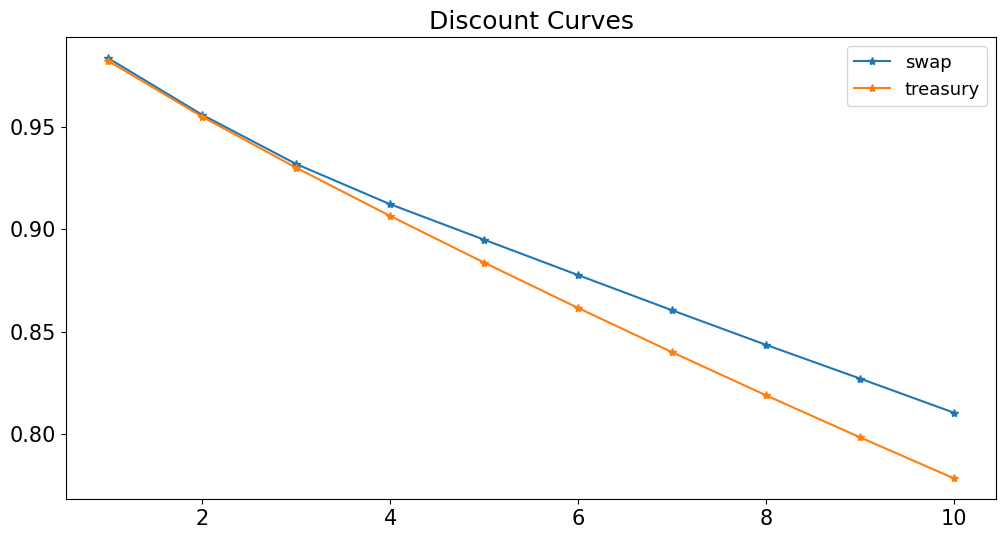

In [28]:
temp = pd.concat([disc,curve_treasury['spot discount']],axis=1).sort_index()
temp.columns = ['swap','treasury']
temp = temp.loc[:GRID_UB,:]
temp.plot(marker='*',linestyle='-',title='Discount Curves')
plt.show()

## Negative Swap Spreads

Prior to the financial crisis of 2008, the swap rate was typically higher than the Treausry rate, partly due to counterparty risk in the swap.

Many things have changed, including...

1. SOFR is a collateralized lending rate, whereas LIBOR was not.

1. Basel III regulation leads to higher capital requirements for anyone trying to take advantage of the swap spread.

2. Furthermore, most swaps are required to go through a Central Clearing Party, virtually eliminating the counterparty risk.

https://www.newyorkfed.org/medialibrary/media/research/epr/2018/epr_2018_negative-swap-spreads_boyarchenko.pdf